In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Pre-processing

In [2]:
# Read in Data
data = pd.read_csv('../data/model_data/spatial_df/Lassa_spatialdataset_201219separateyears_labconfirmed.csv')
data.replace('',np.nan,regex = True)
data = data.dropna()

In [3]:
# Creating LGA names set and then assigning them their indices as values
lga_names = set(data['LGA'])
lga_replace_dict = {value: i for i, value in enumerate(lga_names)}

# Creating Year names set and then assigning them their indices as values
year_names = set(data['Year'])
year_replace_dict = {value: i for i, value in enumerate(year_names)}

# Creating Admin names set and then assigning them their indices as values
administration_names = set(data['admin1Name'])
administration_replace_dict = {value: i for i, value in enumerate(administration_names)}

# Creating Source names set and then assigning them their indices as values
source_names = set(data['Source'])
source_replace_dict = {value: i for i, value in enumerate(source_names)}

In [4]:
# Replaces string values for integer values in dataset
data = data.replace({'LGA':lga_replace_dict, 
                     'Year': year_replace_dict,
                     'admin1Name': administration_replace_dict,
                     'Source': source_replace_dict})

In [5]:
# Features that are already normalized
ignore_norm_cols_array = ["AgriProp_ESA", "UrbanProp_ESA", "ForestProp_ESA", "TempMonthlyCoefv_201118_NOAA",
                     "TotalPop2015_PropUrban", "ImprovedHousingPrev_PopWeighted", "Cropland_prop_ESA2015",
                     "Agri_prop_ESA2015", "Urb_prop_ESA2015", "Forest_prop_ESA2015", "PovertyProp_Mean",
                     "PovertyProp_PopWeighted"]

# Normalize rest of features
for heading in data.columns:  
  if heading not in ignore_norm_cols_array:
    data[heading] = ( data[heading] - ( min(data[heading]) ) ) / ( max(data[heading]) - min(data[heading]) )

# Remove these columns
data = data.loc[:, ~data.columns.isin(['Any_Confirmed_Cases', 'Source', 'x', 'y'])]

## SHAP Heat Map/ Correlation Matrix

<Axes: >

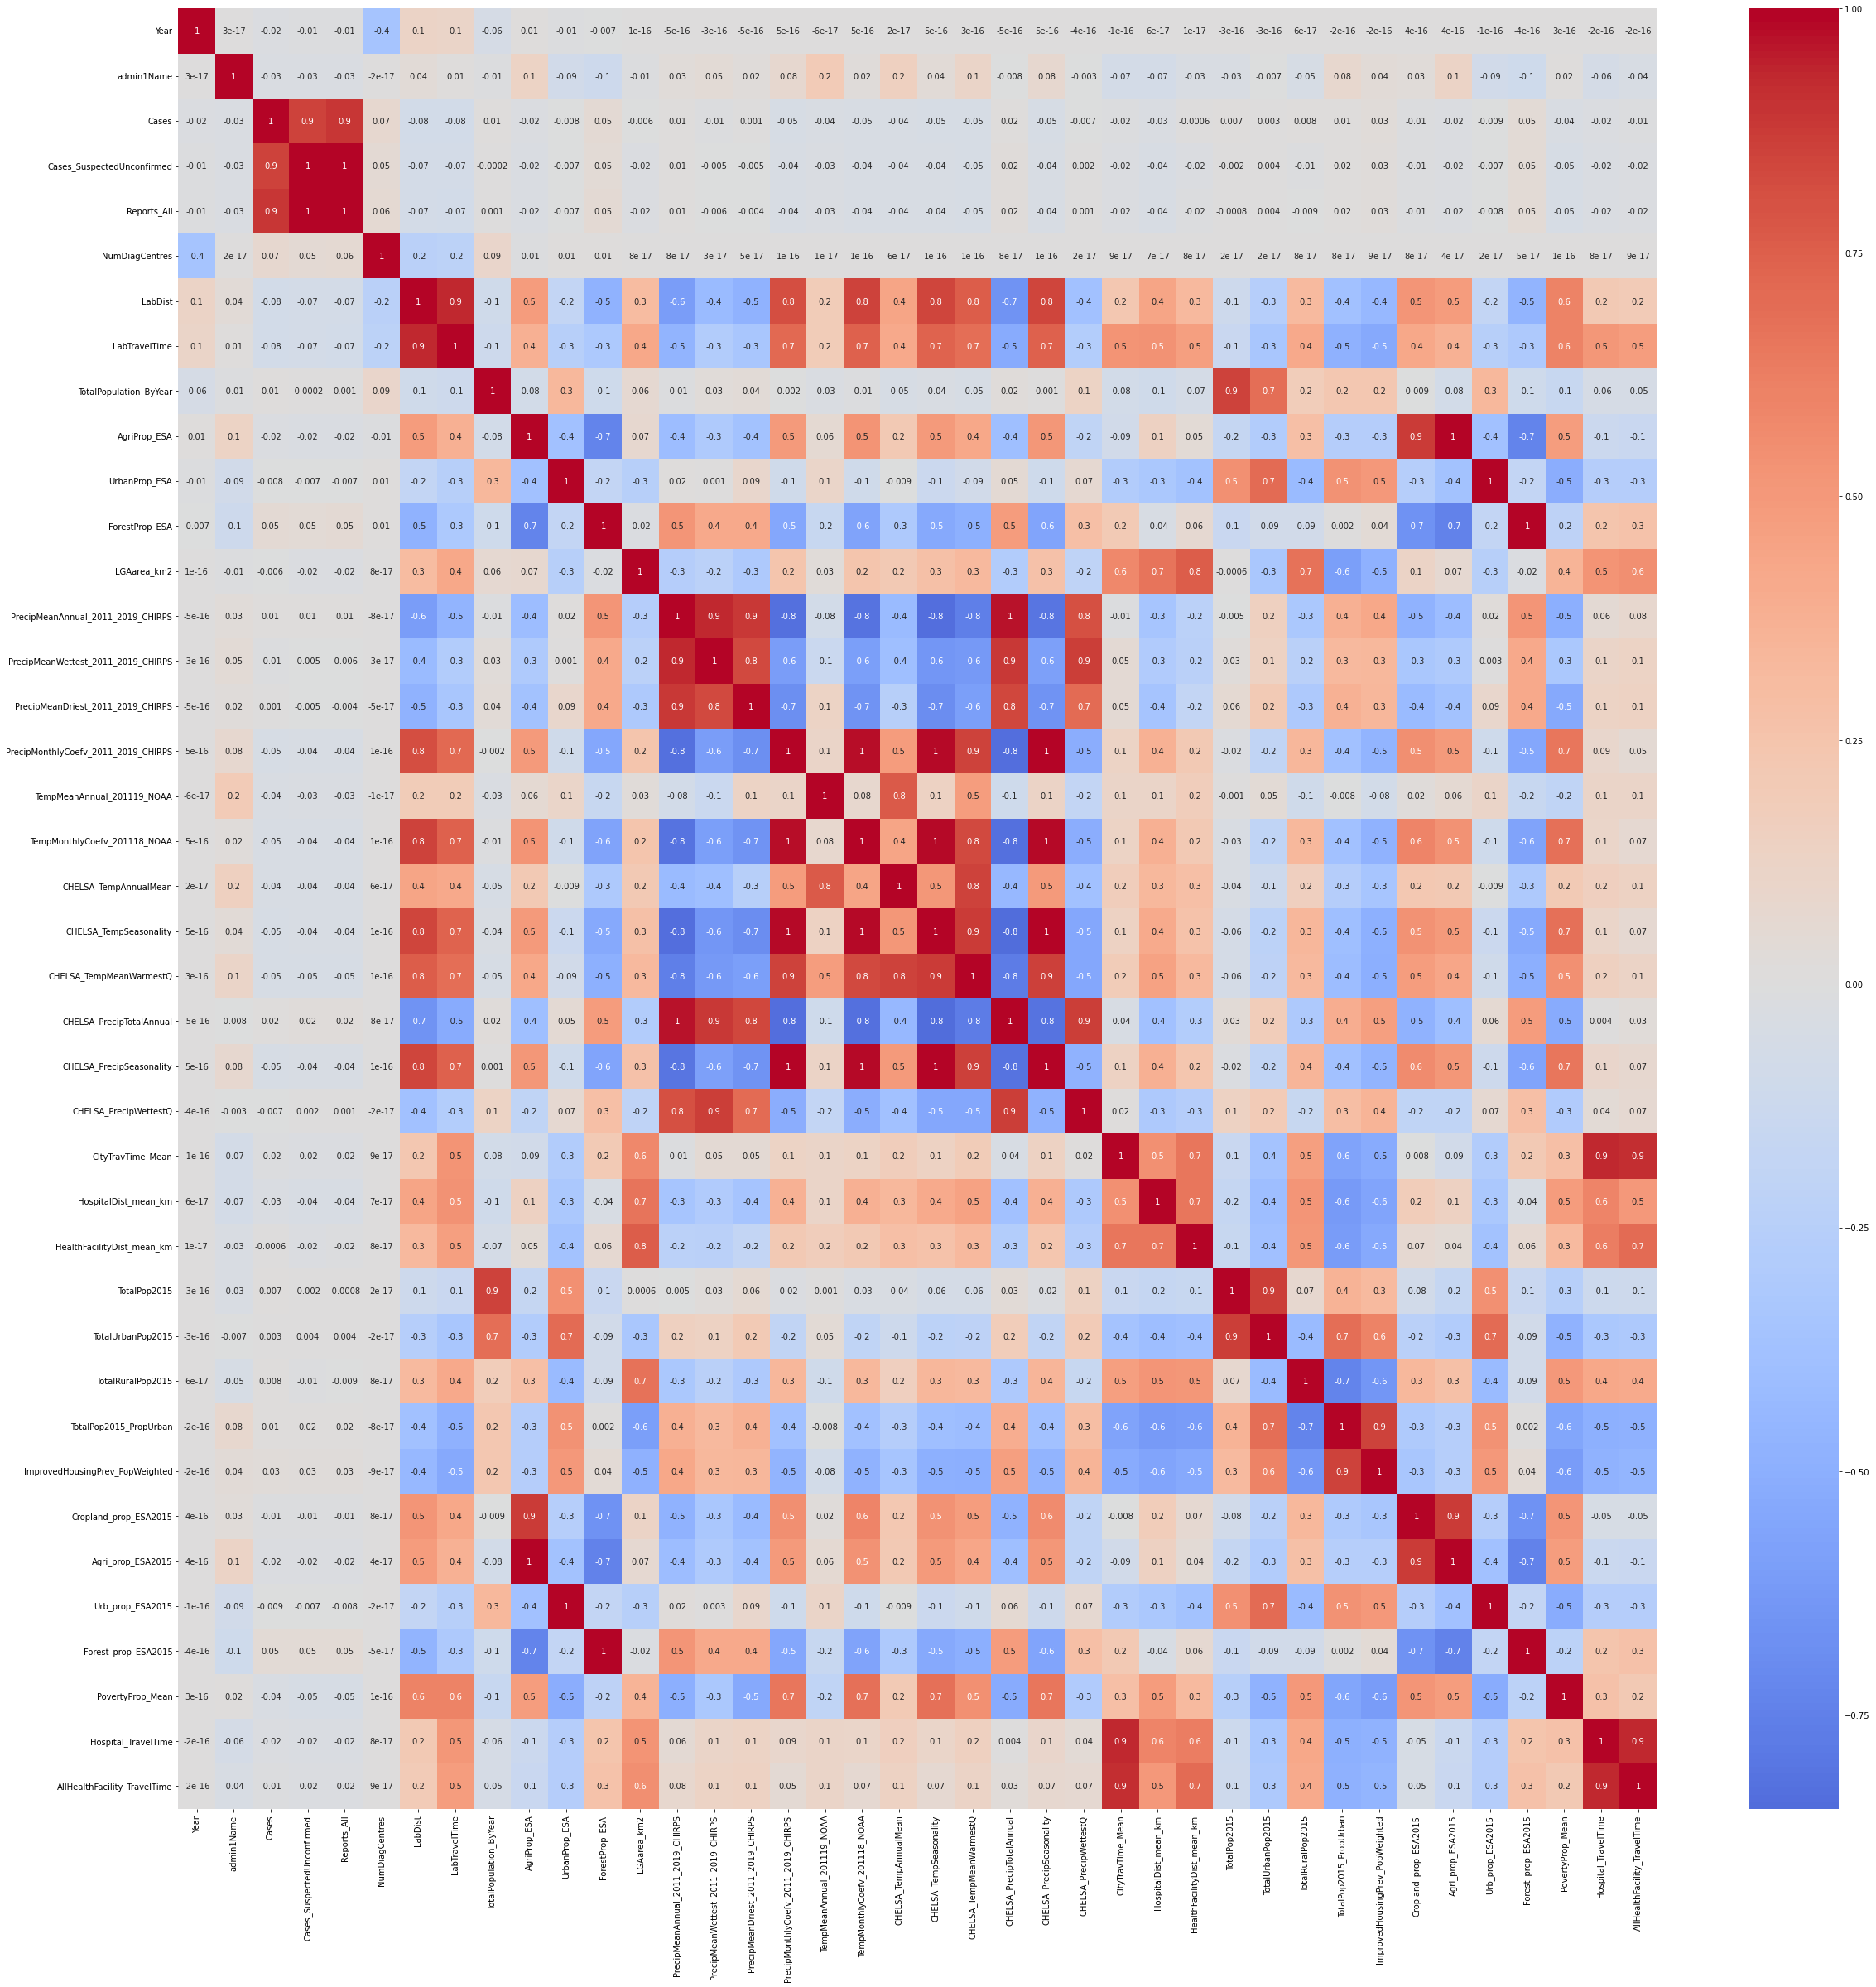

In [7]:
shap_related_columns = ['Year', 'admin1Name', 'Cases', 
                        'Cases_SuspectedUnconfirmed', 'Reports_All', 'NumDiagCentres',
                        'LabDist', 'LabTravelTime', 'TotalPopulation_ByYear', 'AgriProp_ESA',
                        'UrbanProp_ESA', 'ForestProp_ESA', 'LGAarea_km2',
                        'PrecipMeanAnnual_2011_2019_CHIRPS',
                        'PrecipMeanWettest_2011_2019_CHIRPS',
                        'PrecipMeanDriest_2011_2019_CHIRPS',
                        'PrecipMonthlyCoefv_2011_2019_CHIRPS', 'TempMeanAnnual_201119_NOAA',
                        'TempMonthlyCoefv_201118_NOAA', 'CHELSA_TempAnnualMean',
                        'CHELSA_TempSeasonality', 'CHELSA_TempMeanWarmestQ',
                        'CHELSA_PrecipTotalAnnual', 'CHELSA_PrecipSeasonality',
                        'CHELSA_PrecipWettestQ', 'CityTravTime_Mean', 'HospitalDist_mean_km',
                        'HealthFacilityDist_mean_km', 'TotalPop2015',
                        'TotalUrbanPop2015', 'TotalRuralPop2015', 'TotalPop2015_PropUrban',
                        'ImprovedHousingPrev_PopWeighted', 'Cropland_prop_ESA2015',
                        'Agri_prop_ESA2015', 'Urb_prop_ESA2015', 'Forest_prop_ESA2015',
                        'PovertyProp_Mean', 'Hospital_TravelTime',
                        'AllHealthFacility_TravelTime'
                       ]
s_plt = len(shap_related_columns)
fig, ax = plt.subplots(figsize=(s_plt, s_plt))

# Create new DataFrame with just shap related columns
shap_data = data[shap_related_columns]

corr_matrix = pd.DataFrame(shap_data, columns=shap_related_columns).corr()

sns.heatmap(corr_matrix,
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.1g')

## XGBoost Model

In [13]:
x_data = data.iloc[:, data.columns != 'Cases']
x_train, x_test, y_train, y_test = train_test_split(x_data, data['Cases'], test_size=0.2)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
# Create model instance
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=0.01, objective='binary:logistic')
# Fit Model
bst.fit(x_train, y_train)
# Make Predictions
preds = bst.predict(x_test)

sample_index=5
print(f"Predicted Value: {preds[sample_index]}")
print(f"Actual Value: {y_test[sample_index]}")
print(f"Accuracy: {bst.score(x_test, y_test)}")

s=0
for n,i in enumerate(preds):
    if i == y_test[n]:
        s+=1
print(f"Manual Accuracy: {float(s)/float(len(y_test))}")

Predicted Value: 0
Actual Value: 0
Accuracy: 0.9467312348668281
Manual Accuracy: 0.9467312348668281


In [53]:
explainer = shap.Explainer(bst, x_train)
shap_values = explainer(x_train)

 98%|===================| 160456/163449 [00:14<00:00]        

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


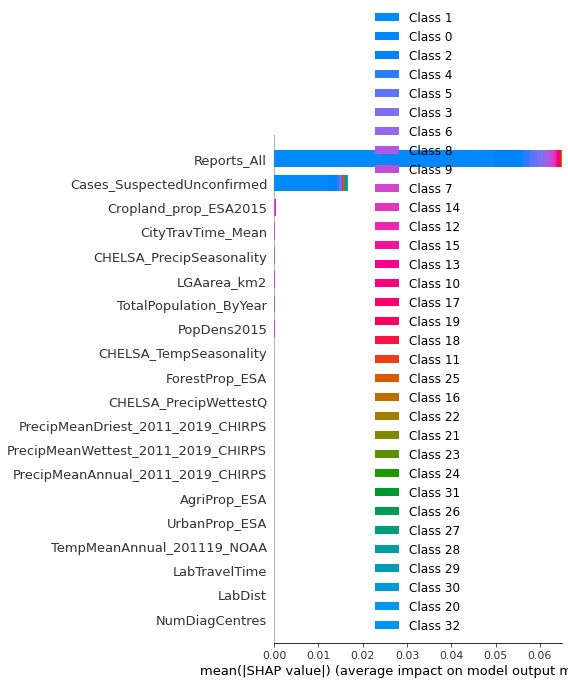

In [60]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, plot_type="bar")

## Beeswarm Plot Stuff

In [ ]:

fig, axes = plt.subplots(nrows=8, ncols=5, figsize=(20,20))

axes = axes.flatten()

for i,feature in enumerate(shap_data.columns):
    sns.swarmplot(x=feature, data=shap_data, ax=axes[i])
    axes[i].set_title(feature)
    
for j in range(len(shap_data.columns), len(axes)):
    axes[j].axis('off')
    
plt.tight_layout()
plt.show()


#fig, ax = plt.subplots(figsize=(20,15))
#sns.stripplot(x='LabTravelTime', data=shap_data, size=1)
#sns.swarmplot(x='LabTravelTime', data=shap_data)
#plt.show()


## Does this even work
# for feature in shap_data.columns:
    #shap.summary_plot(shap_values[:, feature], shap_data[feature], plot_type="beeswarm", show=False)
    #plt.title(feature)
    #plt.show()

79.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
97.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
15.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
97.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
89.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
96.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
97.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
89.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
98.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
96.7% of the points cannot be placed; you may want to d

63.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
91.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


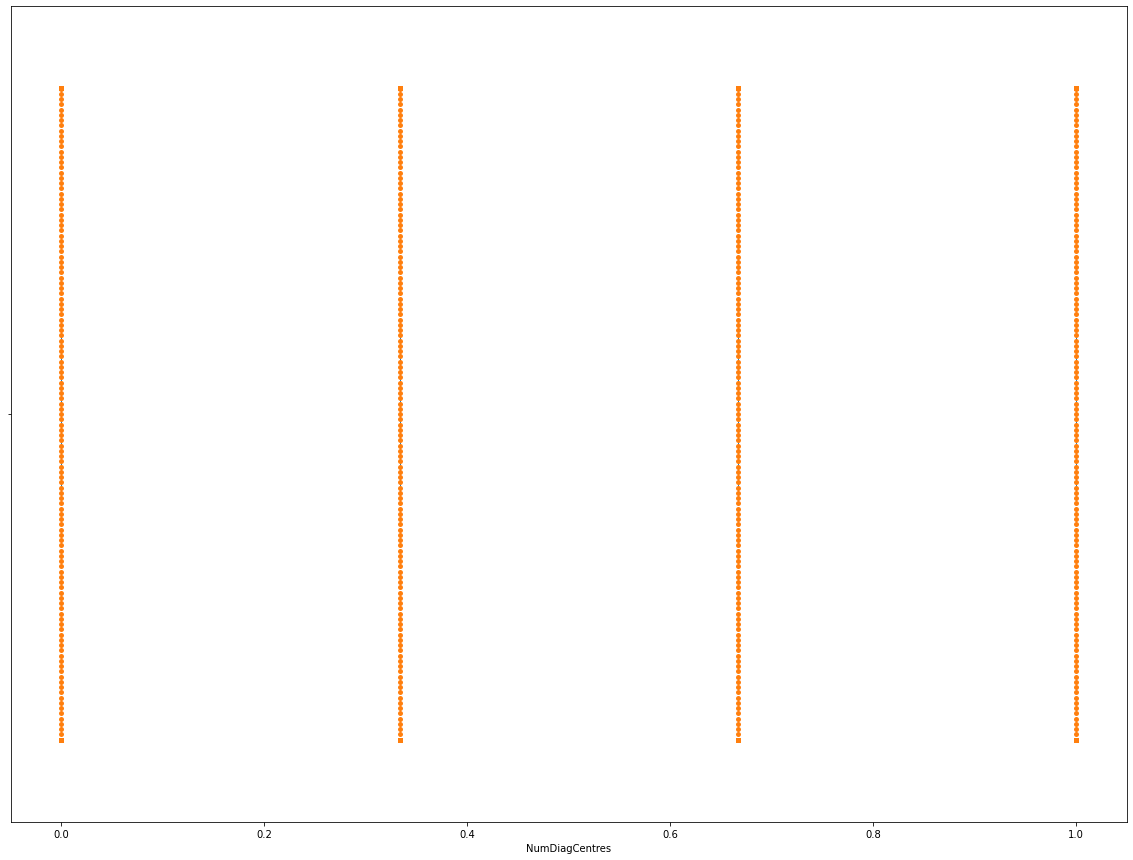

In [62]:
fig, ax = plt.subplots(figsize=(20,15))
sns.stripplot(x='NumDiagCentres', data=shap_data, size=1)
sns.swarmplot(x='NumDiagCentres', data=shap_data)
plt.show()